In [29]:
import random
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_rel
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, ParameterGrid, ParameterSampler, GridSearchCV, cross_val_score, StratifiedKFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from mlxtend.evaluate import bias_variance_decomp

# Import the dataset
df = pd.read_csv("placementdata.csv")
print(df)

      StudentID  CGPA  Internships  Projects  Workshops/Certifications  \
0             1   7.5            1         1                         1   
1             2   8.9            0         3                         2   
2             3   7.3            1         2                         2   
3             4   7.5            1         1                         2   
4             5   8.3            1         2                         2   
...         ...   ...          ...       ...                       ...   
9995       9996   7.5            1         1                         2   
9996       9997   7.4            0         1                         0   
9997       9998   8.4            1         3                         0   
9998       9999   8.9            0         3                         2   
9999      10000   8.4            0         1                         1   

      AptitudeTestScore  SoftSkillsRating ExtracurricularActivities  \
0                    65               4.

Task 1 (30 points): Implement a Decision Tree Classifier for your classification problem. You
may use a built-in package to implement your classifier. Additionally, do the following:
• Visualize the decision tree structure for at least three different parameter settings.
Comment on how the depth and complexity change the tree.
• Do some research on what sensitivity analysis is and how it is performed (include
citations). Perform a sensitivity analysis to measure the impact of at least two input
features on your model's decision boundary.

In [30]:
# Initial Findings and start of EDA
df.info()
print("\nUnique Values\n", df.nunique())
print(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   StudentID                  10000 non-null  int64  
 1   CGPA                       10000 non-null  float64
 2   Internships                10000 non-null  int64  
 3   Projects                   10000 non-null  int64  
 4   Workshops/Certifications   10000 non-null  int64  
 5   AptitudeTestScore          10000 non-null  int64  
 6   SoftSkillsRating           10000 non-null  float64
 7   ExtracurricularActivities  10000 non-null  object 
 8   PlacementTraining          10000 non-null  object 
 9   SSC_Marks                  10000 non-null  int64  
 10  HSC_Marks                  10000 non-null  int64  
 11  PlacementStatus            10000 non-null  object 
dtypes: float64(2), int64(7), object(3)
memory usage: 937.6+ KB

Unique Values
 StudentID                   

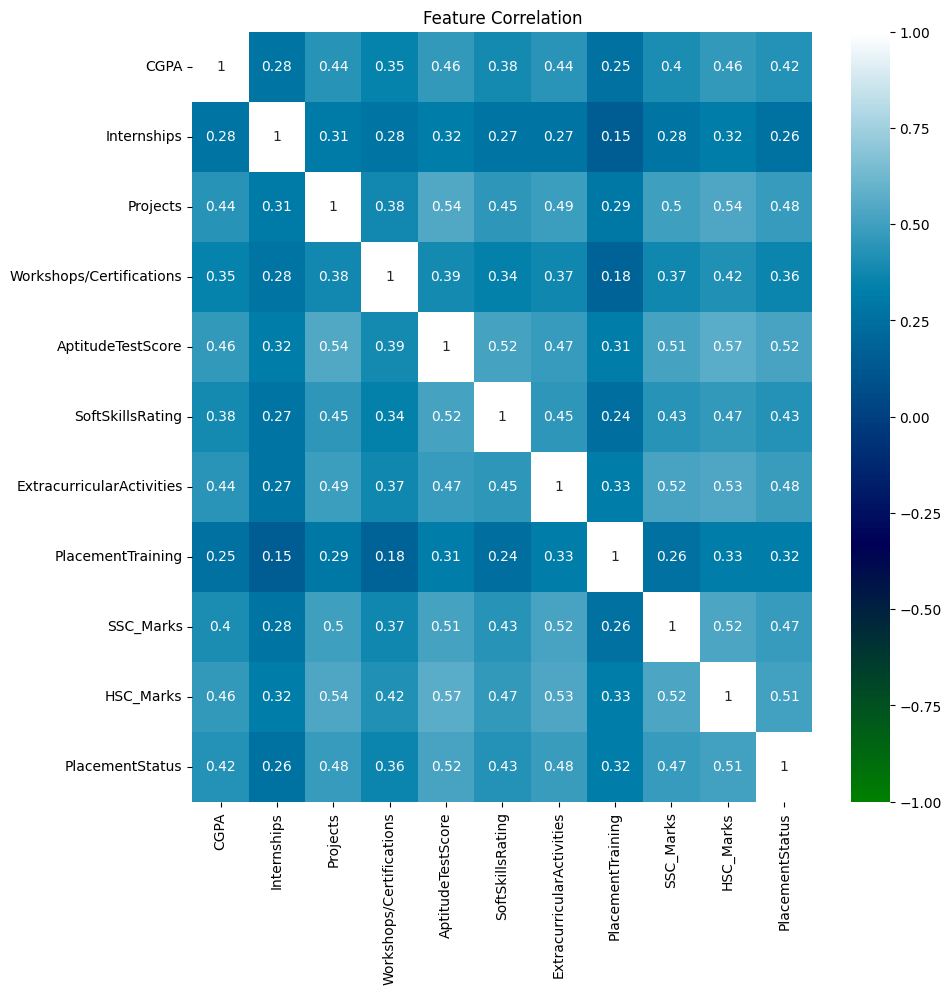

                      Feature         VIF
0                        CGPA  157.602762
1                 Internships    4.118883
2                    Projects   10.914713
3    Workshops/Certifications    2.951076
4           AptitudeTestScore  175.884175
5            SoftSkillsRating  149.032389
6   ExtracurricularActivities    3.909103
7           PlacementTraining    4.471602
8                   SSC_Marks   76.898105
9                   HSC_Marks  133.426858
10            PlacementStatus    2.628116


In [31]:
# ALl columns have more than 1 unique value so we must change str to ints and gauge their correlation to the target value with VIF
# No need for student ID though given that it has a unique value for all data points


# Encode strings into ints for data processing, ie a b c will be encoded to 0 1 2 
label_encoder = preprocessing.LabelEncoder()
df_encoded = df
df_encoded.drop(columns=['StudentID'], axis=1, inplace=True)
df_encoded['PlacementStatus'] = label_encoder.fit_transform(df_encoded['PlacementStatus'])
df_encoded['PlacementTraining'] = label_encoder.fit_transform(df_encoded['PlacementTraining'])
df_encoded['ExtracurricularActivities'] = label_encoder.fit_transform(df_encoded['ExtracurricularActivities'])
corr_matrix = df_encoded.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, annot=True, cmap='ocean', vmin=-1, vmax=1)
plt.title("Feature Correlation")
plt.show()

vif_data = pd.DataFrame()
vif_data['Feature'] = df_encoded.columns
vif_data["VIF"] = [variance_inflation_factor(df_encoded.values, i) for i in range(len(df_encoded.columns))]

print(vif_data)

# We can keep all of the other features since their VIF is greater than 1
# Feature correlation seems very high in this dataset with CGPA, AptitudeTestScore, SoftSkillsRating, SSC_Marks, and HSC_Marks showing the largest numbers for VIF


In [32]:
def evaluate_metrics(y_pred, y_true):
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [33]:
X = df_encoded.copy().drop(['PlacementStatus'], axis=1)
Y = df_encoded.copy()['PlacementStatus']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
classification = DecisionTreeClassifier(random_state=42, max_depth=6)
classification.fit(X_train, y_train)
y_pred = classification.predict(X_test)
metrics = evaluate_metrics(y_test, y_pred)
print(metrics)


print(df.keys()[-1])


{'accuracy': 0.779, 'precision': 0.7634322373696872, 'recall': 0.7212121212121212, 'f1': 0.7417218543046358}
PlacementStatus


In [34]:
# Parameter Tuning with GridSearchCV

param_grid = {
    'max_depth': range(3, 12, 1),
    'min_samples_leaf': range(1, 20, 2),
    'min_samples_split': range(2, 20,2),
    'criterion': ["entropy", "gini"]
}

tree = DecisionTreeClassifier(random_state=42)
gridSearch = GridSearchCV(estimator=tree, param_grid=param_grid, cv=5, verbose=True)
gridSearch.fit(X_train, y_train)

y_pred = gridSearch.predict(X_test)
metrics = evaluate_metrics(y_test, y_pred)
print(metrics)
print(gridSearch.best_estimator_)

Fitting 5 folds for each of 1620 candidates, totalling 8100 fits
{'accuracy': 0.7803333333333333, 'precision': 0.7618283881315157, 'recall': 0.7240853658536586, 'f1': 0.7424775302852676}
DecisionTreeClassifier(max_depth=6, min_samples_leaf=5, min_samples_split=18,
                       random_state=42)


In [35]:
# Derived from param_grid without varying the min_samples_leaf, and min_samples_split parameters
case3 = DecisionTreeClassifier(max_depth=6, random_state=42)
case3.fit(X_train, y_train)
y_pred = case3.predict(X_test)
metrics = evaluate_metrics(y_test, y_pred)
print(metrics)

bias_var_gridSearch = []
vg_expected_loss, avg_bias, avg_var = bias_variance_decomp(case3, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), loss='mse', random_seed=42, num_rounds=10)
bias_var_gridSearch.append([vg_expected_loss, avg_bias, avg_var])
print(bias_var_gridSearch)



{'accuracy': 0.779, 'precision': 0.7634322373696872, 'recall': 0.7212121212121212, 'f1': 0.7417218543046358}
[[0.23373333333333335, 0.17273333333333335, 0.061]]


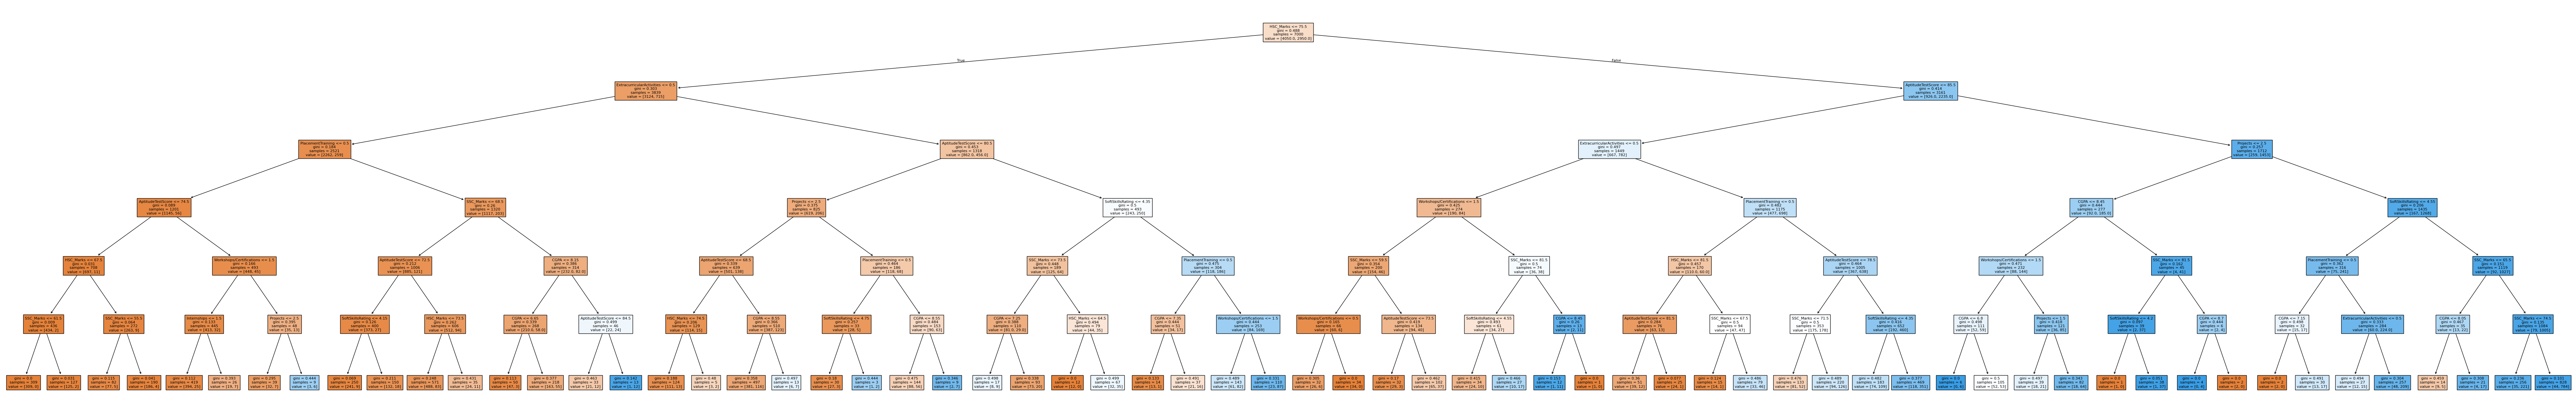

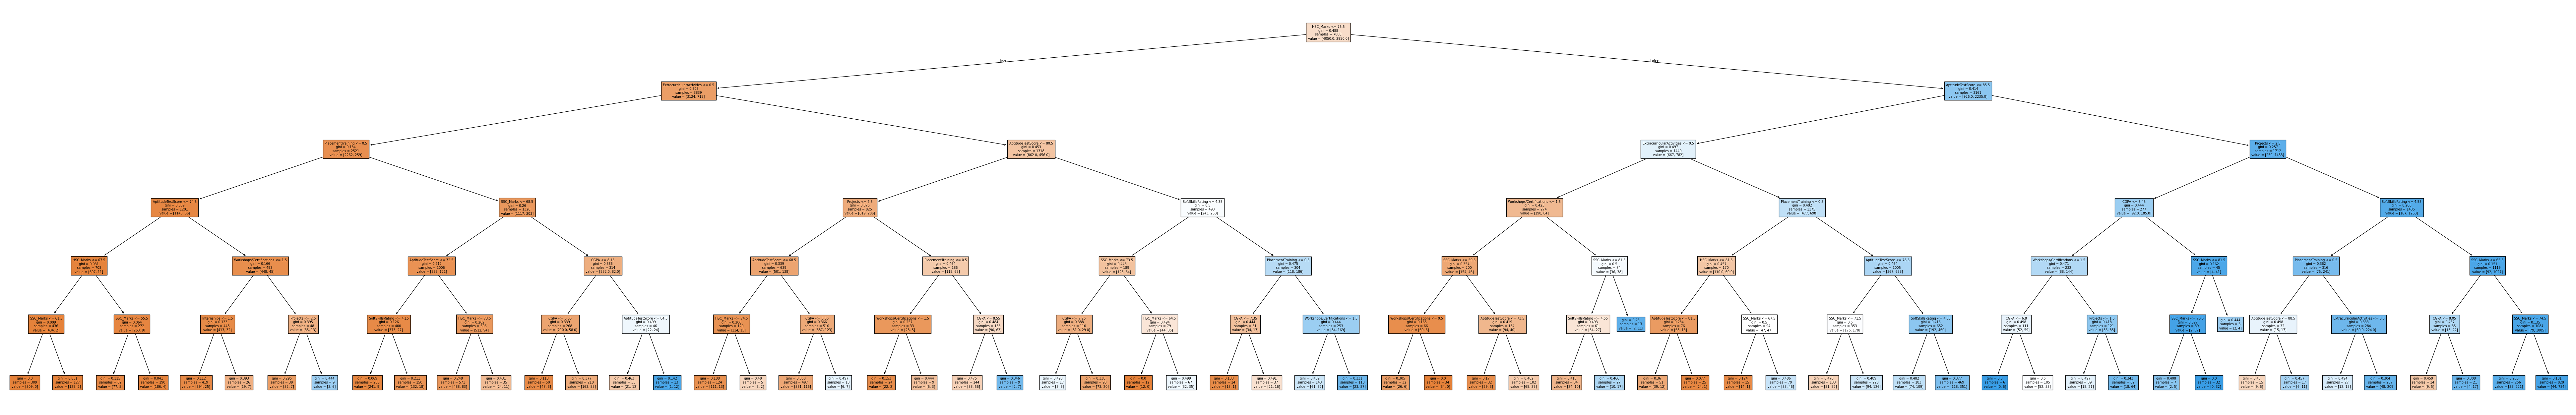

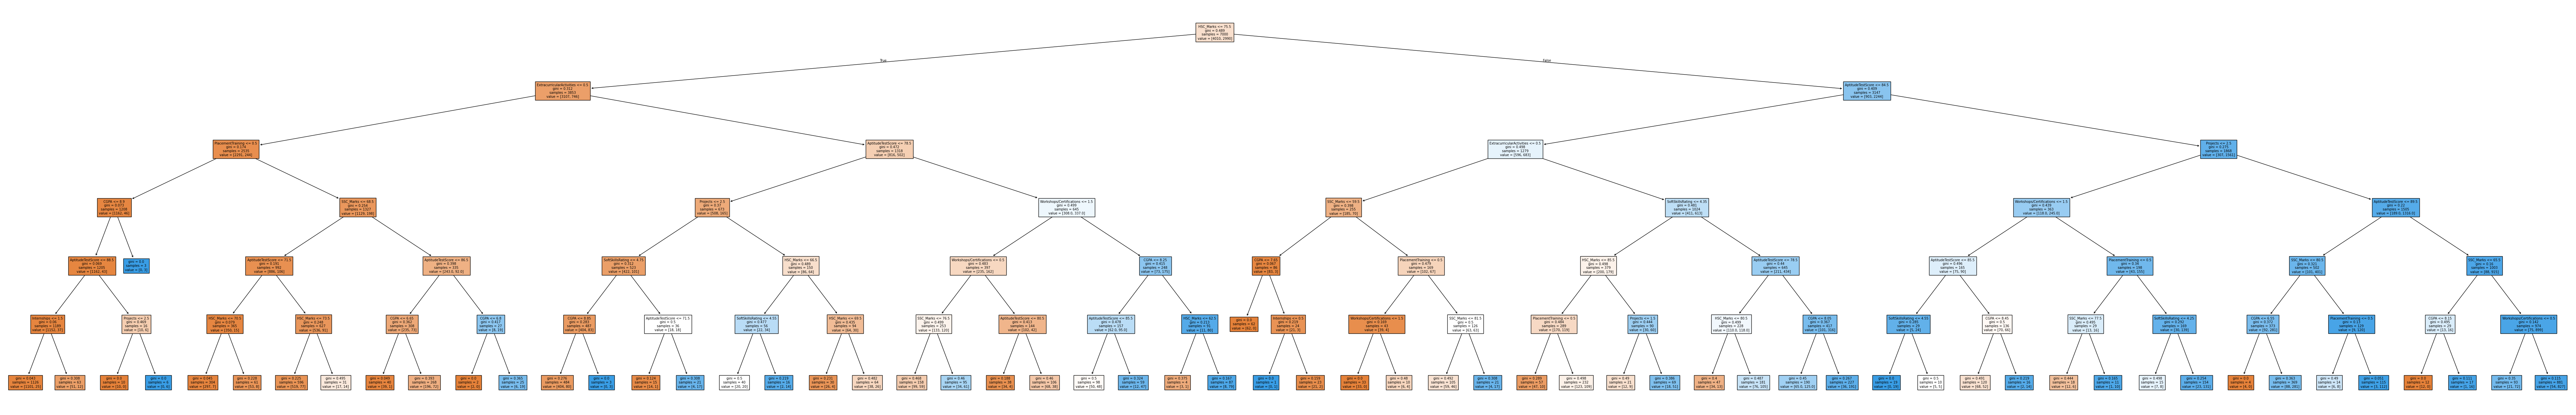

In [36]:
# Visualize the decision tree structure for at least three different parameter settings. Comment on how the depth and complexity change the tree.
plt.figure(figsize=(100, 16))
plot_tree(classification, filled=True, feature_names=df_encoded.keys()[:-1], fontsize=8)
plt.show()

plt.figure(figsize=(100, 16))
plot_tree(gridSearch.best_estimator_, filled=True, feature_names=df_encoded.keys()[:-1], fontsize=7)
plt.show()

plt.figure(figsize=(100, 16))
plot_tree(case3, filled=True, feature_names=df_encoded.keys()[:-1], fontsize=7)
plt.show()

In [37]:
# Perform a sensitivity analysis to measure the impact of at least two input features on your model's decision boundary.
y_pred = gridSearch.predict(X_test)
baseline_accuracy = accuracy_score(y_test, y_pred)


# Perform permutation sensitivity analysis
sensitivity_results = []
n_repeats = 10  # Number of permutations to average the effect

for feature_idx in X_test:
    permuted_accuracies = []
    
    for _ in range(n_repeats):
        # Create a copy of the test set and permute one feature
        X_test_permuted = X_test.copy()
        X_test_permuted[feature_idx] = np.random.permutation(X_test_permuted[feature_idx])  # Permute the feature values
        
        # Evaluate the model on the permuted data
        permuted_accuracy = accuracy_score(y_test, gridSearch.best_estimator_.predict(X_test_permuted))
        permuted_accuracies.append(permuted_accuracy)
    
    # Calculate the drop in accuracy due to permutation
    mean_permuted_accuracy = np.mean(permuted_accuracies)
    sensitivity = baseline_accuracy - mean_permuted_accuracy
    sensitivity_results.append((feature_idx, sensitivity))

In [38]:
# Convert results to a DataFrame for visualization
sensitivity_df = pd.DataFrame(
    sensitivity_results, columns=["Feature Index", "Sensitivity (Drop in Accuracy)"]
)

sensitivity_df["Sensitivity (Drop in Accuracy)"] = sensitivity_df[
    "Sensitivity (Drop in Accuracy)"
].apply(lambda x: "{:.20f}".format(x))

# Sort features by sensitivity
sensitivity_df = sensitivity_df.sort_values(by="Sensitivity (Drop in Accuracy)", ascending=False)

print(sensitivity_df)

# Here we can see that the predicted from above with VIF and our EDA hold fairly true, AptitudeTestScore causes the highest drop in accuracy as well as HSC_marks being there.
# We do see Extracurricular Activities play a role that we couldn't previously see as important same with Placement Training

# citation https://medium.com/@einat_93627/understand-your-black-box-model-using-sensitivity-analysis-practical-guide-ef6ac4175e55

               Feature Index Sensitivity (Drop in Accuracy)
4          AptitudeTestScore         0.03770000000000006679
6  ExtracurricularActivities         0.02453333333333329591
9                  HSC_Marks         0.01476666666666659467
8                  SSC_Marks         0.01219999999999998863
7          PlacementTraining         0.00706666666666666554
5           SoftSkillsRating         0.00533333333333330106
0                       CGPA         0.00496666666666667478
3   Workshops/Certifications         0.00229999999999996874
1                Internships         0.00000000000000000000
2                   Projects        -0.00160000000000004583


Task 2 (30 points): From the Bagging and Boosting ensemble methods pick any one algorithm
from each category. Implement both the algorithms using the same data.

• Use stratified k-fold cross-validation with at least three different folds (e.g., 5, 10, 15).
You may do your own research on this technique (include citations).

• Evaluate the models using any three-evaluation metrics of your choice (e.g. accuracy,
Precision, F1-score etc.).

• Comment on the behavior of each algorithm under the metrics. Does the performance
ranking change based on the metric used? Why?


In [56]:
skf5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
skf15 = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)

best_fold_idx = None
best_accuracy = -1
lst_accu_stratified5bag = []
lst_accu_stratified5boost = []
test_indices_per_fold = []
y_test_per_fold = []
y_pred_per_fold = []
bias_var_bag = []
bias_var_boost = []

forest = RandomForestClassifier(n_estimators=10, random_state=42)
adaBoost = AdaBoostClassifier()

for fold_idx, (train_index, test_index) in enumerate(skf5.split(X, Y)):
    x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = Y.iloc[train_index], Y.iloc[test_index]
    
    # Train and evaluate Random Forest
    forest.fit(x_train_fold, y_train_fold)
    y_pred_forest = forest.predict(x_test_fold)
    lst_accu_stratified5bag.append(evaluate_metrics(y_pred_forest, y_test_fold))

    # Train and evaluate AdaBoost
    adaBoost.fit(x_train_fold, y_train_fold)
    y_pred_adaBoost = adaBoost.predict(x_test_fold)
    lst_accu_stratified5boost.append(evaluate_metrics(y_pred_adaBoost, y_test_fold))
    
for fold_idx, (train_index, test_index) in enumerate(skf10.split(X, Y)):
    x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = Y.iloc[train_index], Y.iloc[test_index]
    
    # Train and evaluate Random Forest
    forest.fit(x_train_fold, y_train_fold)
    y_pred_forest = forest.predict(x_test_fold)
    lst_accu_stratified5bag.append(evaluate_metrics(y_pred_forest, y_test_fold))

    # Train and evaluate AdaBoost
    adaBoost.fit(x_train_fold, y_train_fold)
    y_pred_adaBoost = adaBoost.predict(x_test_fold)
    lst_accu_stratified5boost.append(evaluate_metrics(y_pred_adaBoost, y_test_fold))

for fold_idx, (train_index, test_index) in enumerate(skf15.split(X, Y)):
    x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = Y.iloc[train_index], Y.iloc[test_index]
    
    # Train and evaluate Random Forest
    forest.fit(x_train_fold, y_train_fold)
    y_pred_forest = forest.predict(x_test_fold)
    lst_accu_stratified5bag.append(evaluate_metrics(y_pred_forest, y_test_fold))

    # Train and evaluate AdaBoost
    adaBoost.fit(x_train_fold, y_train_fold)
    y_pred_adaBoost = adaBoost.predict(x_test_fold)
    lst_accu_stratified5boost.append(evaluate_metrics(y_pred_adaBoost, y_test_fold))
    
    vg_expected_loss, avg_bias, avg_var = bias_variance_decomp(forest, np.array(x_train_fold), np.array(y_train_fold), np.array(x_test_fold), np.array(y_test_fold), loss='mse', random_seed=42, num_rounds=10)
    bias_var_bag.append([vg_expected_loss, avg_bias, avg_var])
    
    vg_expected_loss, avg_bias, avg_var = bias_variance_decomp(adaBoost, np.array(x_train_fold), np.array(y_train_fold), np.array(x_test_fold), np.array(y_test_fold), loss='mse', random_seed=42, num_rounds=10)
    bias_var_boost.append([vg_expected_loss, avg_bias, avg_var])
    # Compute accuracy for this fold
    accuracy = accuracy_score(y_test_fold, y_pred_forest)

    # Store test indices, true labels, and predictions for each fold
    test_indices_per_fold.append(test_index)
    y_test_per_fold.append(y_test_fold)
    y_pred_per_fold.append(y_pred_forest)

    # Track the best fold based on accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_fold_idx = fold_idx # Store best fold


In [60]:
# Convert results to DataFrame for easier analysis
df_bag = pd.DataFrame(lst_accu_stratified5bag)
df_boost = pd.DataFrame(lst_accu_stratified5boost)

# Determine the best fold based on a chosen metric (e.g., accuracy)
best_bag_index5 = df_bag.iloc[:5]['accuracy'].idxmax()
best_boost_index5 = df_boost.iloc[:5]['accuracy'].idxmax()
best_bag_index10 = df_bag.iloc[5:16]['accuracy'].idxmax()
best_boost_index10 = df_boost.iloc[5:16]['accuracy'].idxmax()
best_bag_index15 = df_bag.iloc[16:]['accuracy'].idxmax()
best_boost_index15 = df_boost.iloc[16:]['accuracy'].idxmax()

# Retrieve the best results
best_bag_result5 = df_bag.iloc[best_bag_index5]
best_boost_result5 = df_boost.iloc[best_boost_index5]

best_bag_result10 = df_bag.iloc[best_bag_index10]
best_boost_result10 = df_boost.iloc[best_boost_index10]

best_bag_result15 = df_bag.iloc[best_bag_index15]
best_boost_result15 = df_boost.iloc[best_boost_index15]

In [61]:
# Display the best results
print("Best Random Forest Result:")
print('\nk fold = 5\n',best_bag_result5)
print('\nk fold = 10\n',best_bag_result10)
print('\nk fold = 15\n',best_bag_result15)

Best Random Forest Result:

k fold = 5
 accuracy     0.783000
precision    0.793054
recall       0.653159
f1           0.716340
Name: 1, dtype: float64

k fold = 10
 accuracy     0.798000
precision    0.794595
recall       0.700000
f1           0.744304
Name: 11, dtype: float64

k fold = 15
 accuracy     0.793103
precision    0.808696
recall       0.664286
f1           0.729412
Name: 18, dtype: float64


In [62]:
print("Best ADABoost Result:")
print('\nk fold = 5\n', best_boost_result5)
print('\nk fold = 10\n',best_boost_result10)
print('\nk fold = 15\n',best_boost_result15)

Best ADABoost Result:

k fold = 5
 accuracy     0.809500
precision    0.785536
recall       0.750894
f1           0.767824
Name: 1, dtype: float64

k fold = 10
 accuracy     0.816000
precision    0.781775
recall       0.778043
f1           0.779904
Name: 7, dtype: float64

k fold = 15
 accuracy     0.824324
precision    0.816406
recall       0.749104
f1           0.781308
Name: 25, dtype: float64


Task 3 (40 points): Compare the effectiveness of the three models implemented above. Analyze
the results using the following:

• A confusion matrix for one selected test fold.

• A statistical test (e.g., paired t-test) to determine if differences between models are
significant.

• A discussion on the trade-off between bias and variance for each model

In [66]:
print('\nThe Best Result from Bagging with Random Forest, k fold = 10\n',best_bag_result15)
print('\nThe Best Result from Boosting with ADAboost,k fold = 15\n',best_boost_result15)

# Results from GridSearchCV
y_pred = gridSearch.predict(X_test)
metrics = evaluate_metrics(y_test, y_pred)
print('\nThe Best Result from The hyperparameter tuned Decision Tree Classifier with GridSearchCV\n', metrics)


The Best Result from Bagging with Random Forest, k fold = 10
 accuracy     0.793103
precision    0.808696
recall       0.664286
f1           0.729412
Name: 18, dtype: float64

The Best Result from Boosting with ADAboost,k fold = 15
 accuracy     0.824324
precision    0.816406
recall       0.749104
f1           0.781308
Name: 25, dtype: float64

The Best Result from The hyperparameter tuned Decision Tree Classifier with GridSearchCV
 {'accuracy': 0.7803333333333333, 'precision': 0.7618283881315157, 'recall': 0.7240853658536586, 'f1': 0.7424775302852676}


Best fold index based on accuracy: 3
Confusion Matrix for Random Forest (Best Fold):


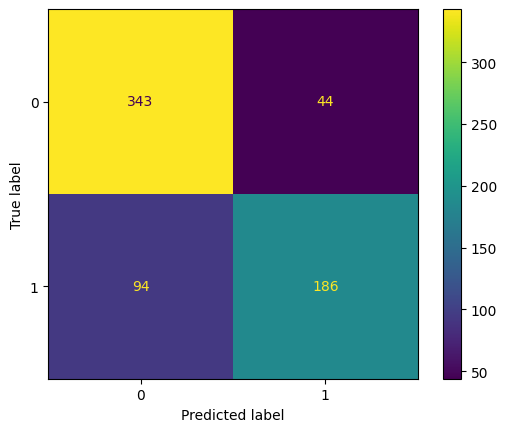

In [67]:
print(f"Best fold index based on accuracy: {best_fold_idx}")

# Retrieve the test indices, true labels, and predictions for the best fold
test_index_selected = test_indices_per_fold[best_fold_idx]
y_test_selected = y_test_per_fold[best_fold_idx]
y_pred_forest_selected = y_pred_per_fold[best_fold_idx]

# Generate and display confusion matrix
conf_matrix_forest = confusion_matrix(y_test_selected, y_pred_forest_selected)
print("Confusion Matrix for Random Forest (Best Fold):")

disp_forest = ConfusionMatrixDisplay(conf_matrix_forest)
disp_forest.plot()

We see that the model had a higher rate of False Positives compared to False Negatives, when considering the data we are working with, placement data, it might be worth considering a model that punishes false postives more than false negatives. If we consider a student wanting to know whether they will place or not, I know I'd rather be a false negative than a false postive.

In [68]:
# Extract accuracies from all folds for both models
forest_accuracies = df_bag["accuracy"]
adaBoost_accuracies = df_boost["accuracy"]

# Perform paired t-test
t_stat, p_value = ttest_rel(forest_accuracies, adaBoost_accuracies)

# Display results
print(f"\nPaired t-test results:")
print(f"T-statistic: {t_stat:.10f}")
print(f"P-value: {p_value:.20f}")

alpha = 0.05  # Significance level
if p_value < alpha:
    print("The difference between the models is statistically significant.")
else:
    print("No significant difference between the models.")


Paired t-test results:
T-statistic: -12.8950521780
P-value: 0.00000000000015475726
The difference between the models is statistically significant.


In [74]:
print(bias_var_gridSearch)
print(bias_var_bag[best_bag_index15-15])
print(bias_var_boost[best_boost_index15-15])

[[0.23373333333333335, 0.17273333333333335, 0.061]]
[0.20359820089955022, 0.14164917541229385, 0.06194902548725638]
[0.17882882882882883, 0.15734234234234235, 0.02148648648648649]


1. Decision Tree Classification with Grid Search CV
-   Does a good job with tuning hyperparameters to prevent over/under fitting the data, but in order to test all parameters to find the most optimal you would require huge computing costs given the exponential nature of testing parameters
-   Shows a higher Bias than Variance, this might be because of a more shallow tree that simplifies the devision boundary at the cost of generalization
2. Bagging with Random Forest and Stratified K-Fold CV (15 Folds)
-   Overall lower Bias but relatively similar Variance to the Decision Tree classification with GridSearch. Lower computing cost as well due to no need for hyperparameter tuning.
-   The method of random forest leads to less overfitting, which is shown in the bias variance tradeoff.
3. Boosting with ADAboos and Stratified K-Fold CV (15 folds)
-   Saw the lowest bais + var out of all three options due to the lowest var we've seen while having a relatively low bias.
-   Interesting to think about given that adaboost works by combining multiple weak learners and then learn from mistakes. Would love to dive deeper and maybe take a look on how the amount of k-folds could further impact the results